In [1]:
# Imports
# ---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt

folder0 = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/q12021/'
folder1 = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/1oxaria/json/gap_filling/q12021/'
folder2 = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/2oxaria/json/gap_filling/q12021/'

# List of good Oxaria1 location names to zip with tags
# mus be in numerical order of tags
# ------------------------------------------------------
ox1_location_names = ['High St', 'South Parks Rd', 'St Ebbes', 'Jesus College',
                      'New Marston', 'The Plain', 'Worcester College', 'John Radcliffe']

# List of good Oxaria2 location names to zip with tags
# mus be in numerical order of tags
# ------------------------------------------------------
ox2_location_names = ['Windmill School1', 'Said Business School', 'County Hall',
                      'Divinity Road', 'Jahlul Bayt Mosque', 'Windmill School2', 'St Giles',
                      'Warneford Hospital', 'Spare', 'Speedwell St']

In [3]:
# Function to load stable Oxaria feathers & aggregate to 15-min minute
# ----------------------------------------------------------------------

def resample_15min(in_ftr, out_ftr):
    df = pd.read_feather(in_ftr).set_index(['tag', 'rec'])
    df = df.groupby([pd.Grouper(level='tag'),
                     pd.Grouper(level='rec',
                                freq='15min',
                                label='right',
                                convention='end',
                                origin='epoch'
                                )]).mean()
    df = df.astype({col: 'int32' for col in
                    df.select_dtypes('int64').columns})
    df = df.astype({col: np.float32 for col in
                    df.select_dtypes('float64').columns})
    df.reset_index(inplace=True)
    df['rec'] = df['rec'].dt.strftime('%Y-%m-%d %H:%M:%S.%f%z')
    df['rec'] = pd.to_datetime(df['rec'],
                               errors='coerce',
                               utc=True,
                               unit='ns',
                               origin='unix',
                               infer_datetime_format=True)
    df.to_feather(out_ftr)
    return df

def pollutant_transients(df):
    df_list = []
    for tag, dat in df.groupby('tag'):
        dat['hmd_s20'] = dat.loc[:,['val.sht.hmd']].diff(2).div(20)
        dat['tmp_s20'] = dat.loc[:,['val.sht.tmp']].diff(2).div(20)
        df1 = dat[['hmd_s20','tmp_s20']].resample('15T',closed='right',label='right',level=1).mean()
        df2 = dat[['hmd_s20','tmp_s20']].resample('15T',closed='right',label='right',level=1).max()
        df3 = dat[['hmd_s20','tmp_s20']].resample('15T',closed='right',label='right',level=1).min()
        df4 = pd.merge(left=df2,right=df3,left_index=True, right_index=True)
        df4['mag_hmd_s20'] = np.where(abs(df4['hmd_s20_x']) > abs(df4['hmd_s20_y']),df4['hmd_s20_x'],df4['hmd_s20_y'])
        df4['mag_tmp_s20'] = np.where(abs(df4['tmp_s20_x']) > abs(df4['tmp_s20_y']),df4['tmp_s20_x'],df4['tmp_s20_y'])
        df4 = pd.merge(left=df4,right=df1,left_index=True, right_index=True)
        df4 = df4.drop(columns=['hmd_s20_x','hmd_s20_y','tmp_s20_x','tmp_s20_y'])
        df4.rename(columns={'hmd_s20':'mean_hmd_s20', 'tmp_s20':'mean_tmp_s20'}, inplace=True)
        df4['tag'] = tag
        df4 = df4.reset_index().set_index(['tag','rec']).sort_index()
        df_list.append(df4)
    df5 = pd.concat(df_list)
    return df5

def climate_transients(df):
    df_list = []
    for tag, dat in df.groupby('tag'):
        dat['hmd_s20c'] = dat.loc[:,['val.hmd']].diff(2).div(20)
        dat['tmp_s20c'] = dat.loc[:,['val.tmp']].diff(2).div(20)
        df1 = dat[['hmd_s20c','tmp_s20c']].resample('15T',closed='right',label='right',level=1).mean()
        df2 = dat[['hmd_s20c','tmp_s20c']].resample('15T',closed='right',label='right',level=1).max()
        df3 = dat[['hmd_s20c','tmp_s20c']].resample('15T',closed='right',label='right',level=1).min()
        df4 = pd.merge(left=df2,right=df3,left_index=True, right_index=True)
        df4['mag_hmd_s20c'] = np.where(abs(df4['hmd_s20c_x']) > abs(df4['hmd_s20c_y']),df4['hmd_s20c_x'],df4['hmd_s20c_y'])
        df4['mag_tmp_s20c'] = np.where(abs(df4['tmp_s20c_x']) > abs(df4['tmp_s20c_y']),df4['tmp_s20c_x'],df4['tmp_s20c_y'])
        df4 = pd.merge(left=df4,right=df1,left_index=True, right_index=True)
        df4 = df4.drop(columns=['hmd_s20c_x','hmd_s20c_y','tmp_s20c_x','tmp_s20c_y'])
        df4.rename(columns={'hmd_s20c':'mean_hmd_s20c', 'tmp_s20c':'mean_tmp_s20c'}, inplace=True)
        df4['tag'] = tag
        df4 = df4.reset_index().set_index(['tag','rec']).sort_index()
        df_list.append(df4)
    df5 = pd.concat(df_list)
    return df5


In [4]:
# Calc 15-min averages for space &n comparison with auto data - oxaria1
# -----------------------------------------------------------------------

# Apply resample function
oxaria1_climate_stable_15min = resample_15min(in_ftr=folder1+'oxaria1_climate_stable_536_q12021.ftr',
                                              out_ftr=folder1+'oxaria1_climate_stable_536_q12021_15min.ftr')

oxaria1_status_stable_15min = resample_15min(in_ftr=folder1+'oxaria1_status_stable_536_q12021.ftr',
                                             out_ftr=folder1+'oxaria1_status_stable_536_q12021_15min.ftr')

oxaria1_gases_stable_15min = resample_15min(in_ftr=folder1+'oxaria1_gases_stable_536_q12021.ftr',
                                            out_ftr=folder1+'oxaria1_gases_stable_536_q12021_15min.ftr')

oxaria1_pm_stable_15min = resample_15min(in_ftr=folder1+'oxaria1_pm_stable_536_q12021.ftr',
                                         out_ftr=folder1+'oxaria1_pm_stable_536_q12021_15min.ftr')

# Special function for transients
df = pd.read_feather(folder1+'oxaria1_climate_stable_536_q12021.ftr').set_index(['tag','rec'])
oxaria1_climate_stable_15min_transients = climate_transients(df=df)
df = pd.read_feather(folder1+'oxaria1_pm_stable_536_q12021.ftr').set_index(['tag','rec'])
oxaria1_pm_stable_15min_transients = pollutant_transients(df=df)
df = pd.read_feather(folder1+'oxaria1_gases_stable_536_q12021.ftr').set_index(['tag','rec'])
oxaria1_gases_stable_15min_transients = pollutant_transients(df=df)

oxaria1_climate_stable_15min.info()
oxaria1_climate_stable_15min_transients.info()
oxaria1_gases_stable_15min.info()
oxaria1_gases_stable_15min_transients.info()
oxaria1_pm_stable_15min.info()
oxaria1_pm_stable_15min_transients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113888 entries, 0 to 113887
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype              
---  ------   --------------   -----              
 0   tag      113888 non-null  object             
 1   rec      113888 non-null  datetime64[ns, UTC]
 2   val.hmd  113888 non-null  float32            
 3   val.tmp  113888 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(2), object(1)
memory usage: 2.6+ MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115968 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   mag_hmd_s20c   113888 non-null  float32
 1   mag_tmp_s20c   113888 non-null  float32
 2   mean_hmd_s20c  113888 non-null  float32
 3   mean_tmp_s20c  113888 non-null  float32
dtypes:

In [5]:
# Calc 15-min averages for space &n comparison with auto data - oxaria2
# -----------------------------------------------------------------------

# Apply resample function
oxaria2_climate_stable_15min = resample_15min(in_ftr=folder2+'oxaria2_climate_stable_536_q12021.ftr',
                                              out_ftr=folder2+'oxaria2_climate_stable_536_q12021_15min.ftr')

oxaria2_status_stable_15min = resample_15min(in_ftr=folder2+'oxaria2_status_stable_536_q12021.ftr',
                                             out_ftr=folder2+'oxaria2_status_stable_536_q12021_15min.ftr')

oxaria2_gases_stable_15min = resample_15min(in_ftr=folder2+'oxaria2_gases_stable_536_q12021.ftr',
                                            out_ftr=folder2+'oxaria2_gases_stable_536_q12021_15min.ftr')

oxaria2_pm_stable_15min = resample_15min(in_ftr=folder2+'oxaria2_pm_stable_536_q12021.ftr',
                                         out_ftr=folder2+'oxaria2_pm_stable_536_q12021_15min.ftr')

# Special function for transients
df = pd.read_feather(folder2+'oxaria2_climate_stable_536_q12021.ftr').set_index(['tag','rec'])
oxaria2_climate_stable_15min_transients = climate_transients(df=df)
df = pd.read_feather(folder2+'oxaria2_pm_stable_536_q12021.ftr').set_index(['tag','rec'])
oxaria2_pm_stable_15min_transients = pollutant_transients(df=df)
df = pd.read_feather(folder2+'oxaria2_gases_stable_536_q12021.ftr').set_index(['tag','rec'])
oxaria2_gases_stable_15min_transients = pollutant_transients(df=df)

oxaria2_climate_stable_15min.info()
oxaria2_climate_stable_15min_transients.info()
oxaria2_gases_stable_15min.info()
oxaria2_gases_stable_15min_transients.info()
oxaria2_pm_stable_15min.info()
oxaria2_pm_stable_15min_transients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121001 entries, 0 to 121000
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype              
---  ------   --------------   -----              
 0   tag      121001 non-null  object             
 1   rec      121001 non-null  datetime64[ns, UTC]
 2   val.hmd  121001 non-null  float32            
 3   val.tmp  121001 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(2), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 128074 entries, ('scs-bgx-550', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   mag_hmd_s20c   121001 non-null  float32
 1   mag_tmp_s20c   121001 non-null  float32
 2   mean_hmd_s20c  121001 non-null  float32
 3   mean_tmp_s20c  121001 non-null  float32
dtypes:

In [6]:
# Add names back on to the dfs, they get lost by resample
# ---------------------------------------------------------

# functions for oxaria1
def add_names_1oxaria(df):
    ox1_location_names = ['High St', 'South Parks Rd', 'St Ebbes', 'Jesus College',
                          'Marsten', 'The Plain', 'Worcester College', 'John Radcliffe']
    devices = df.reset_index()['tag'].unique()
    device_names = dict(zip(devices, ox1_location_names))
    df_device_names = pd.DataFrame.from_dict(device_names,
                                             orient='index',
                                             columns=['name'
                                                      ])
    df_device_names.index.name = 'tag'
    dfout = df.reset_index().merge(df_device_names,
                     how='left',
                     left_on='tag',
                     right_on='tag').set_index(['tag','rec'])
    try:
        dfout.drop(columns=['index'], inplace=True)
    except:
        pass
    return dfout

# functions for oxaria2


def add_names_2oxaria(df):
    ox2_location_names = ['Windmill School1', 'Said Business School', 'County Hall', 'Divinity Road',
                          'Jahlul Bayt Mosque', 'Windmill School2', 'St Giles', 'Warneford Hospital',
                          'Spare', 'Speedwell St']
    devices = df.reset_index()['tag'].unique()
    device_names = dict(zip(devices, ox2_location_names))
    df_device_names = pd.DataFrame.from_dict(device_names,
                                             orient='index',
                                             columns=['name'
                                                      ])
    df_device_names.index.name = 'tag'
    dfout = df.reset_index().merge(df_device_names,
                     how='left',
                     left_on='tag',
                     right_on='tag').set_index(['tag','rec'])
    try:
        dfout.drop(columns=['index'], inplace=True)
    except:
        pass
    return dfout


# Applying the functions to the dfs
# -----------------------------------
# non-transients oxaria1
oxaria1_gases_stable_15min = add_names_1oxaria(oxaria1_gases_stable_15min)
oxaria1_pm_stable_15min = add_names_1oxaria(oxaria1_pm_stable_15min)
oxaria1_climate_stable_15min = add_names_1oxaria(oxaria1_climate_stable_15min)
# transients oxaria1
oxaria1_gases_stable_15min_transients = add_names_1oxaria(
    oxaria1_gases_stable_15min_transients)
oxaria1_pm_stable_15min_transients = add_names_1oxaria(
    oxaria1_pm_stable_15min_transients)
oxaria1_climate_stable_15min_transients = add_names_1oxaria(
    oxaria1_climate_stable_15min_transients)
# status
oxaria1_status_stable_15min = add_names_1oxaria(oxaria1_status_stable_15min)

# non-transients oxaria2
oxaria2_gases_stable_15min = add_names_2oxaria(oxaria2_gases_stable_15min)
oxaria2_pm_stable_15min = add_names_2oxaria(oxaria2_pm_stable_15min)
oxaria2_climate_stable_15min = add_names_2oxaria(oxaria2_climate_stable_15min)
# transients oxaria2
oxaria2_gases_stable_15min_transients = add_names_2oxaria(
    oxaria2_gases_stable_15min_transients)
oxaria2_pm_stable_15min_transients = add_names_2oxaria(
    oxaria2_pm_stable_15min_transients)
oxaria2_climate_stable_15min_transients = add_names_2oxaria(
    oxaria2_climate_stable_15min_transients)
# status
oxaria2_status_stable_15min = add_names_2oxaria(oxaria2_status_stable_15min)

# Some house keeping, don't know why, an earlier step
# oxaria2_climate_stable_15min.drop(columns=['index'],inplace=True)

In [7]:
oxaria1_climate_stable_15min_transients

mag_hmd_s20c  mag_tmp_s20c  \
tag         rec                                                     
scs-bgx-536 2021-01-01 00:15:00+00:00        -0.040        -0.005   
            2021-01-01 00:30:00+00:00        -0.020        -0.005   
            2021-01-01 00:45:00+00:00        -0.065        -0.005   
            2021-01-01 01:00:00+00:00         0.055        -0.010   
            2021-01-01 01:15:00+00:00        -0.030        -0.005   
...                                             ...           ...   
scs-bgx-543 2021-05-31 23:00:00+00:00         0.020        -0.005   
            2021-05-31 23:15:00+00:00         0.020        -0.010   
            2021-05-31 23:30:00+00:00         0.015        -0.010   
            2021-05-31 23:45:00+00:00         0.040        -0.005   
            2021-06-01 00:00:00+00:00        -0.035        -0.005   

                                       mean_hmd_s20c  mean_tmp_s20c  \
tag         rec                                                       
scs-bgx-536 2021-01-01 00:15:00+00:00      -0.006154      -0.000769   
            2021-01-01 00:30:00+00:00      -0.005000       0.001667   
            2021-01-01 00:45:00+00:00      -0.001667       0.000333   
            2021-01-01 01:00:00+00:00       0.010667      -0.003333   
            2021-01-01 01:15:00+00:00       0.002333      -0.000333   
...                                              ...            ...   
scs-bgx-543 2021-05-31 23:00:00+00:00       0.012333      -0.002000   
            2021-05-31 23:15:00+00:00       0.011667      -0.003000   
            2021-05-31 23:30:00+00:00       0.003000      -0.000333   
            2021-05-31 23:45:00+00:00       0.009667      -0.001333   
            2021-06-01 00:00:00+00:00      -0.002333      -0.000667   

                                                 name  
tag         rec                                        
scs-bgx-536 2021-01-01 00:15:00+00:00         High St  
            2021-01-01 00:30:00+00:00         High St  
            2021-01-01 00:45:00+00:00         High St  
            2021-01-01 01:00:00+00:00         High St  
            2021-01-01 01:15:00+00:00         High St  
...                                               ...  
scs-bgx-543 2021-05-31 23:00:00+00:00  John Radcliffe  
            2021-05-31 23:15:00+00:00  John Radcliffe  
            2021-05-31 23:30:00+00:00  John Radcliffe  
            2021-05-31 23:45:00+00:00  John Radcliffe  
            2021-06-01 00:00:00+00:00  John Radcliffe  

[115968 rows x 5 columns]

In [8]:
# Combine oxaria 1 & 2 gases + some checks to show all is the same
#------------------------------------------------------------------
oxaria_gases_stbl15 = pd.concat([oxaria1_gases_stable_15min,
                                 oxaria2_gases_stable_15min])#.set_index(['tag','rec'])

oxaria_gases_stbl15_transients = pd.concat([oxaria1_gases_stable_15min_transients,
                                            oxaria2_gases_stable_15min_transients])#.set_index(['tag','rec'])

oxaria_gases_stbl15_t = oxaria_gases_stbl15.merge(
    oxaria_gases_stbl15_transients, left_index=True, right_index=True, how='inner')

oxaria_gases_stbl15 = oxaria_gases_stbl15_t[~oxaria_gases_stbl15_t.index.duplicated(
    keep='last')].sort_index()

oxaria_gases_stbl15.info()
oxaria_gases_stbl15_t.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 232000 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   val.no2.wev       232000 non-null  float32
 1   val.no2.cnc       231680 non-null  float32
 2   val.no2.aev       232000 non-null  float32
 3   val.no2.wec       231680 non-null  float32
 4   val.sht.hmd       231680 non-null  float32
 5   val.sht.tmp       231680 non-null  float32
 6   val.no2.cnc_1     226897 non-null  float32
 7   name_x            232000 non-null  object 
 8   exg.vb20.no2.cnc  24624 non-null   float32
 9   mag_hmd_s20       231679 non-null  float32
 10  mag_tmp_s20       231679 non-null  float32
 11  mean_hmd_s20      231679 non-null  float32
 12  mean_tmp_s20      231679 non-null  float32
 13  name_y            232000 non-null  object 


In [9]:
oxaria2_gases_stable_15min#_transients

val.no2.wev  val.no2.cnc  val.no2.aev  \
tag         rec                                                                
scs-bgx-550 2021-01-01 00:15:00+00:00     0.291218    43.398888     0.289523   
            2021-01-01 00:30:00+00:00     0.291412    44.561798     0.289466   
            2021-01-01 00:45:00+00:00     0.291490    44.604446     0.289514   
            2021-01-01 01:00:00+00:00     0.291498    45.145557     0.289431   
            2021-01-01 01:15:00+00:00     0.291386    45.386665     0.289302   
...                                            ...          ...          ...   
scs-bgx-559 2021-05-31 23:00:00+00:00     0.292921    37.139999     0.295182   
            2021-05-31 23:15:00+00:00     0.292010    34.072224     0.295132   
            2021-05-31 23:30:00+00:00     0.291826    32.986668     0.295194   
            2021-05-31 23:45:00+00:00     0.291789    32.344444     0.295274   
            2021-06-01 00:00:00+00:00     0.291764    33.067417     0.295163   

                                       val.no2.wec  val.sht.hmd  val.sht.tmp  \
tag         rec                                                                
scs-bgx-550 2021-01-01 00:15:00+00:00    -0.002229    83.291115     0.098889   
            2021-01-01 00:30:00+00:00    -0.001958    82.544945     0.052809   
            2021-01-01 00:45:00+00:00    -0.001949    82.965553     0.114444   
            2021-01-01 01:00:00+00:00    -0.001823    82.727776     0.015556   
            2021-01-01 01:15:00+00:00    -0.001766    83.042221    -0.103333   
...                                            ...          ...          ...   
scs-bgx-559 2021-05-31 23:00:00+00:00     0.004212    52.351112    19.682222   
            2021-05-31 23:15:00+00:00     0.003411    53.340000    19.397778   
            2021-05-31 23:30:00+00:00     0.003127    54.397778    19.153334   
            2021-05-31 23:45:00+00:00     0.002961    54.983334    18.988890   
            2021-06-01 00:00:00+00:00     0.003150    56.139324    18.728090   

                                       exg.vb20.no2.cnc  val.no2.cnc_1  \
tag         rec                                                          
scs-bgx-550 2021-01-01 00:15:00+00:00               NaN      43.398888   
            2021-01-01 00:30:00+00:00               NaN      44.561798   
            2021-01-01 00:45:00+00:00               NaN      44.604446   
            2021-01-01 01:00:00+00:00               NaN      45.145557   
            2021-01-01 01:15:00+00:00               NaN      45.386665   
...                                                 ...            ...   
scs-bgx-559 2021-05-31 23:00:00+00:00         17.153334      37.139999   
            2021-05-31 23:15:00+00:00         14.005556      34.072224   
            2021-05-31 23:30:00+00:00         13.541111      32.986668   
            2021-05-31 23:45:00+00:00         14.450000      32.344444   
            2021-06-01 00:00:00+00:00         13.864045      33.067417   

                                                   name  
tag         rec                                          
scs-bgx-550 2021-01-01 00:15:00+00:00  Windmill School1  
            2021-01-01 00:30:00+00:00  Windmill School1  
            2021-01-01 00:45:00+00:00  Windmill School1  
            2021-01-01 01:00:00+00:00  Windmill School1  
            2021-01-01 01:15:00+00:00  Windmill School1  
...                                                 ...  
scs-bgx-559 2021-05-31 23:00:00+00:00      Speedwell St  
            2021-05-31 23:15:00+00:00      Speedwell St  
            2021-05-31 23:30:00+00:00      Speedwell St  
            2021-05-31 23:45:00+00:00      Speedwell St  
            2021-06-01 00:00:00+00:00      Speedwell St  

[119500 rows x 9 columns]

In [10]:
# Combine oxaria 1 & 2 pm + some checks to show all is the same
#------------------------------------------------------------------
oxaria_pm_stbl15 = pd.concat([oxaria1_pm_stable_15min,
                                 oxaria2_pm_stable_15min])

oxaria_pm_stbl15_transients = pd.concat([oxaria1_pm_stable_15min_transients,
                                            oxaria2_pm_stable_15min_transients])

oxaria_pm_stbl15_t = oxaria_pm_stbl15.merge(
    oxaria_pm_stbl15_transients, left_index=True, right_index=True, how='inner')

oxaria_pm_stbl15 = oxaria_pm_stbl15_t[~oxaria_pm_stbl15_t.index.duplicated(
    keep='last')].sort_index()

oxaria_pm_stbl15.info()
oxaria_pm_stbl15_t.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 237686 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   val.mtf1      237686 non-null  float32
 1   val.pm1       237686 non-null  float32
 2   val.mtf5      237686 non-null  float32
 3   val.pm2p5     237686 non-null  float32
 4   val.mtf3      237686 non-null  float32
 5   val.pm10      237686 non-null  float32
 6   val.mtf7      237686 non-null  float32
 7   val.per       237686 non-null  float32
 8   val.sfr       237686 non-null  float32
 9   val.sht.hmd   237686 non-null  float32
 10  val.sht.tmp   237686 non-null  float32
 11  val.pm10_1    169665 non-null  float32
 12  val.pm2p5_1   169665 non-null  float32
 13  val.pm1_1     169665 non-null  float32
 14  name_x        237686 non-null  object 
 15  mag_hmd_s20   2

In [11]:
# Combine oxaria 1 & 2 climate + some checks to show all is the same
#--------------------------------------------------------------------
oxaria_climate_stbl15 = pd.concat([oxaria1_climate_stable_15min,
                                 oxaria2_climate_stable_15min])

oxaria_climate_stbl15_transients = pd.concat([oxaria1_climate_stable_15min_transients,
                                            oxaria2_climate_stable_15min_transients])

oxaria_climate_stbl15_t = oxaria_climate_stbl15.merge(
    oxaria_climate_stbl15_transients, left_index=True, right_index=True, how='inner')

oxaria_climate_stbl15 = oxaria_climate_stbl15_t[~oxaria_climate_stbl15_t.index.duplicated(
    keep='last')].sort_index()

oxaria_climate_stbl15.info()
oxaria_climate_stbl15_t.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 234889 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   val.hmd        234889 non-null  float32
 1   val.tmp        234889 non-null  float32
 2   name_x         234889 non-null  object 
 3   mag_hmd_s20c   234889 non-null  float32
 4   mag_tmp_s20c   234889 non-null  float32
 5   mean_hmd_s20c  234889 non-null  float32
 6   mean_tmp_s20c  234889 non-null  float32
 7   name_y         234889 non-null  object 
dtypes: float32(6), object(2)
memory usage: 10.2+ MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 234889 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 8 columns):
 #   Column         Non-Null Count 

In [12]:
# Combine oxaria 1 & 2 status + some checks to show all is the same
#--------------------------------------------------------------------
oxaria_status_stbl15 = pd.concat([oxaria1_status_stable_15min,
                                 oxaria2_status_stable_15min])
oxaria_status_stbl15.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 238401 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   val.gps.pos:0      236441 non-null  float32
 1   val.gps.pos:1      236441 non-null  float32
 2   val.gps.elv        236441 non-null  float32
 3   val.gps.qual       237517 non-null  float32
 4   val.up.load.av15   238401 non-null  float32
 5   val.up.load.av1    238401 non-null  float32
 6   val.up.load.av5    238401 non-null  float32
 7   val.up.users       238401 non-null  float32
 8   val.psu.prot-batt  238359 non-null  float32
 9   val.psu.chg        157941 non-null  float32
 10  val.psu.standby    113888 non-null  float32
 11  val.psu.pwr-in     238359 non-null  float32
 12  val.psu.host-3v3   238359 non-null  float32
 13  val.psu.batt-flt   113888 no

<AxesSubplot:xlabel='rec'>

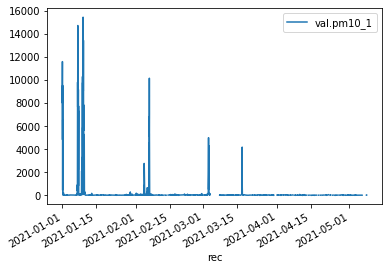

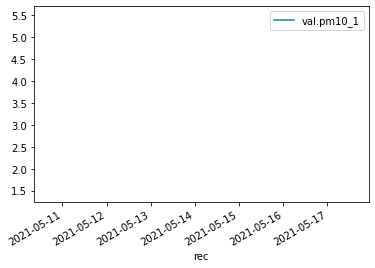

In [2]:
pm = pd.read_feather(
    folder0 + 'oxaria_pm_536_stable15_q12021_transients.ftr')
pm.query('tag in ["scs-bgx-550"]').plot(x='rec',y='val.pm10_1')
pm.query('tag in ["scs-bgx-555"]').plot(x='rec',y='val.pm10_1')

In [13]:
# Write some fts files
#----------------------
oxaria_gases_stbl15.reset_index().to_feather(folder0 + 'oxaria_gases_536_stable15_q12021_transients.ftr')
oxaria_pm_stbl15.reset_index().to_feather(folder0 + 'oxaria_pm_536_stable15_q12021_transients.ftr')
oxaria_climate_stbl15.reset_index().to_feather(folder0 + 'oxaria_climate_536_stable15_q12021_transients.ftr')
oxaria_status_stbl15.reset_index().to_feather(folder0 + 'oxaria_status_536_stable15_q12021_transients.ftr')

oxaria_gases_stbl15.info()
oxaria_pm_stbl15.info()
oxaria_climate_stbl15.info()
oxaria_status_stbl15.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 232000 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   val.no2.wev       232000 non-null  float32
 1   val.no2.cnc       231680 non-null  float32
 2   val.no2.aev       232000 non-null  float32
 3   val.no2.wec       231680 non-null  float32
 4   val.sht.hmd       231680 non-null  float32
 5   val.sht.tmp       231680 non-null  float32
 6   val.no2.cnc_1     226897 non-null  float32
 7   name_x            232000 non-null  object 
 8   exg.vb20.no2.cnc  24624 non-null   float32
 9   mag_hmd_s20       231679 non-null  float32
 10  mag_tmp_s20       231679 non-null  float32
 11  mean_hmd_s20      231679 non-null  float32
 12  mean_tmp_s20      231679 non-null  float32
 13  name_y            232000 non-null  object 
